In [1]:
import pandas as pd
df = pd.read_csv('LR2.csv', sep=',', encoding='cp1251')
df

,id,text
0,1,Рассматриваем схемы подключения и распиновку п...
1,2,Плата Uno по версии R2 снабжается дополнительн...
2,3,Изменения распиновки платы выглядят следующим ...
3,4,Аналоговые входы №0 – №3 с выводами.Аналоговые...
4,5,повышена помехоустойчивость по цепи сброса;уве...
...,...,...
73,74,Схемотехника [102] позволяет компенсировать ем...
74,75,Рис. 48. Внешний вид ультразвукового преобразо...
75,76,Скорость автомобиля для всех датчиков — прибли...
76,77,"Таким образом, существенные ограничения технол..."


In [2]:
import re
from pymorphy2 import MorphAnalyzer
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
patterns = "[A-Za-z0-9!#$%&№'-()*+,./:;<=>?@[\]«»^_`{|}~—\"\--]+"
stopwords_ru = stopwords.words("russian")
stopwords_ru.extend(['это','рис','очень','мочь','иллюстрация'])
morph = MorphAnalyzer() 
def lemmatize(doc):
    doc = re.sub(patterns, ' ', doc)
    tokens = []
    for token in doc.split():
        if token:
            token = token.strip()
            token = morph.normal_forms(token)[0]
            if token not in stopwords_ru:
                tokens.append(token)
    if len(tokens) > 2:
        return tokens
    return None 


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Andrey\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [3]:
data_ready = df['text'].apply(lemmatize)
data_ready

0     [рассматривать, схема, подключение, распиновка...
1     [плата, версия, снабжаться, дополнительный, по...
2     [изменение, распиновка, плата, выглядеть, след...
3     [аналоговый, вход, –, вывод, аналоговый, вход,...
4     [повысить, помехоустойчивость, цепь, сброс, ув...
                            ...                        
73    [схемотехник, позволять, компенсировать, ёмкос...
74    [внешний, вид, ультразвуковой, преобразователь...
75    [скорость, автомобиль, весь, датчик, приблизит...
76    [образ, существенный, ограничение, технология,...
77    [система, помощь, парковка, компания, начинать...
Name: text, Length: 78, dtype: object

In [4]:
text_clean= []
for index, row in df.iterrows():
        text_clean.append(row['text'].split())

from gensim.models import Phrases
bigram = Phrases(text_clean) 
trigram = Phrases(bigram[text_clean])

for idx in range(len(text_clean)):
    for token in bigram[text_clean[idx]]:
        if '_' in token: 
            text_clean[idx].append(token) 
    for token in trigram[text_clean[idx]]:
        if '_' in token:
            text_clean[idx].append(token) 

In [5]:
import gensim
import gensim.corpora as corpora
#Создаем словарь и корпус
id2word = corpora.Dictionary(data_ready)
corpus = [id2word.doc2bow(text) for text in data_ready]
# Строим модель
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=6, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=10,
                                           passes=1,
                                           alpha='symmetric',
                                           per_word_topics=True)
print(lda_model.print_topics())


[(0, '0.092*"автомобиль" + 0.049*"датчик" + 0.031*"водитель" + 0.016*"который" + 0.011*"автомобильный" + 0.010*"рынок" + 0.010*"машина" + 0.009*"компания" + 0.009*"например" + 0.008*"любой"'), (1, '0.024*"ультразвуковой" + 0.023*"устройство" + 0.017*"система" + 0.015*"преобразователь" + 0.014*"также" + 0.012*"внешний" + 0.010*"диафрагма" + 0.010*"сигнал" + 0.010*"частота" + 0.009*"импульс"'), (2, '0.016*"объект" + 0.014*"сторона" + 0.013*"распространение" + 0.011*"знак" + 0.010*"разместить" + 0.010*"основание" + 0.008*"согласно" + 0.007*"случай" + 0.007*"действие" + 0.007*"некоторый"'), (3, '0.013*"диафрагма" + 0.011*"преобразователь" + 0.010*"устройство" + 0.010*"ультразвуковой" + 0.010*"система" + 0.010*"уровень" + 0.009*"случай" + 0.008*"функция" + 0.007*"сигнал" + 0.007*"самый"'), (4, '0.024*"ситуация" + 0.022*"система" + 0.019*"цель" + 0.010*"влиять" + 0.009*"должный" + 0.008*"производитель" + 0.008*"результат" + 0.007*"большой" + 0.007*"стена" + 0.006*"автомобиль"'), (5, '0.039*"

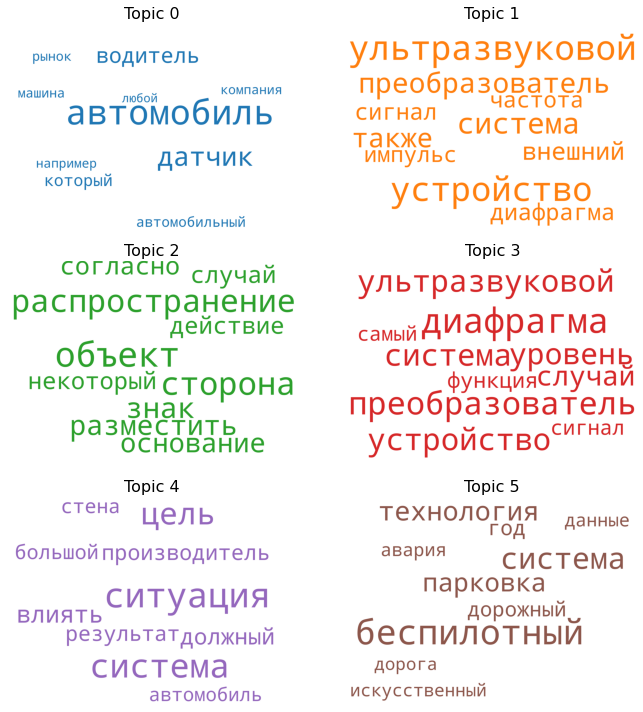

In [6]:
from matplotlib import pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import matplotlib.colors as mcolors
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  
cloud = WordCloud(stopwords=stopwords_ru,
                  background_color='white',
                  width=2500,
                  height=1800,
                  max_words=10,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)
topics = lda_model.show_topics(formatted=False)
fig, axes = plt.subplots(3, 2, figsize=(10,10), sharex=True, sharey=True)
for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
    plt.gca().axis('off')
plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()


In [7]:
import matplotlib.pyplot as plt
import pyLDAvis.gensim

vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word, mds='mmds')
pyLDAvis.save_html(vis, 'D:/LDA_Tischenko.html')

c:\users\andrey\appdata\local\programs\python\python37\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


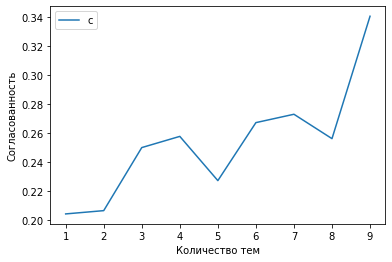

In [8]:
from gensim.models.ldamulticore import LdaMulticore
from gensim.models import CoherenceModel
def compute_coherence_values(dictionary, corpus, texts, limit, start=1, step=1):
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model=LdaMulticore(corpus=corpus,id2word=dictionary, num_topics=num_topics)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())
    return model_list, coherence_values

model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=data_ready, start=1, limit=10, step=1)

limit=10; start=1; step=1;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Количество тем")
plt.ylabel("Согласованность")
plt.legend(("coherence_values"), loc='best')
plt.show()


In [9]:
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 8))

Num Topics = 1  has Coherence Value of 0.20412758
Num Topics = 2  has Coherence Value of 0.20638782
Num Topics = 3  has Coherence Value of 0.24984071
Num Topics = 4  has Coherence Value of 0.25756075
Num Topics = 5  has Coherence Value of 0.22707605
Num Topics = 6  has Coherence Value of 0.26704393
Num Topics = 7  has Coherence Value of 0.27280549
Num Topics = 8  has Coherence Value of 0.25600127
Num Topics = 9  has Coherence Value of 0.34035392


c:\users\andrey\appdata\local\programs\python\python37\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
